# 1. System Setup

In [2]:
import json
import pickle
from astropy.table import Table, Column
import gensim
import sys
from nltk.corpus import stopwords 
import numpy as np
from datetime import datetime
from gensim.test.utils import common_texts, get_tmpfile, common_dictionary, common_corpus
from gensim.models import Word2Vec, LsiModel 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import scipy.io as sio
from pprint import pprint

/usr/local/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [3]:
# tsne plot function
def tsne_plot(models, key_word, topn=5):
    labels = []
    tokens = []
    key_labels = []
    
    cnt = 1
    for model in models:
        tokens.append(model[key_word])
        labels.append(key_word+str(cnt))
        key_labels.append(key_word+str(cnt))
        cnt += 1
        for word in model.similar_by_word(key_word, topn=topn):
            word = word[0]
            if word not in labels:
                tokens.append(model[word])
                labels.append(word)
                
#     tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    tsne_model = TSNE(n_components=2, metric = 'euclidean', random_state=919)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(12, 12))
    plt.box(False)
    
    for i in range(len(x)):
        if labels[i] not in key_labels:
            plt.scatter(x[i],y[i], c='k')
            plt.text(x[i]+1, y[i]+1, labels[i], size=16)
        else:
            plt.scatter(x[i],y[i], s=100, marker='^', c='r')
            plt.text(x[i]+1, y[i]+1, labels[i], color='r', size=18)

    plt.axis('off')
#     plt.savefig(key_word+'.pdf')    
    plt.show()

In [4]:
# helper functions
def find_ngram(article, named_entities):
    for ne in named_entities:
        index = article.find(ne)
        if index != -1:
            ne_to_be_replaced = "_".join(ne.split())
            article = article[:index] + ne_to_be_replaced+article[index+len(ne):]
    return article

def get_real_time(time):
    return datetime.fromtimestamp(time/1000)

def get_timestamp(date):
    # format: %d/%m/%Y, e.g. 01/10/2018
    res = datetime.strptime(date, '%d/%m/%Y').strftime("%s")
    return res

def split_by_date(data, date):
    # split one data into two based on the date
    data_1 = []
    data_2 = []
    time = get_timestamp(date)
    time = int(time)*1000
    for datum in data:
        datum_time = datum[4].split('\n')[0]
        if datum_time != 'N':
            datum_time = int(datum_time)
            if datum_time < time:
                data_1.append(datum)
            else:
                data_2.append(datum)
    return data_1, data_2

def get_news(data):
    stc = []
    for datum in data:
        ctnt = datum[2].split()
        stc.append(ctnt)
    return stc

def get_table(models, key, time_labels, topn=10):
    table = np.array([[]])
    time_list = ['Rank']
    
    count = 0
    for model, time_label in zip(models, time_labels):
        count += 1
        time_list.append(time_label)
        similar_word_and_score = model.similar_by_word(key, topn=topn)
        similar_word = np.array(similar_word_and_score)[:,0]
        if table.shape == (1,0):
            table = np.hstack((table, [similar_word]))
        else:
            table = np.vstack((table, similar_word))
            
    ind = np.array([np.arange(1, topn+1)])
#     print(ind.T.shape, table.shape)
    table = np.append(ind.T, table.T, axis=1)
            
    return Table(rows=table, names=(time_list))

In [5]:
def drift_by_similarity(models, key_word, topn=5):
#  need to find another way, instead of difference by the last one and first one
#  1. difference of cosine similarities  2. difference of the Euclidean distance between the word’s embedding at
#  the last and at the first time slice.
    
    words_dict = {}
    for model in models:
        for word in model.similar_by_word(key_word, topn=topn):
            word = word[0]
            if word in models[0] and word in models[1] and word in models[2] and \
            word in models[3] and word in models[4] and word in models[5]:
                if word not in words_dict:
                    words_dict[word] = 0
                    
    cos_similarity = lambda vec1, vec2 : np.dot(vec1, vec2)/(np.linalg.norm(vec1) * np.linalg.norm(vec2))
    for word in words_dict:
        init_sim = cos_similarity(models[0][key_word], models[0][word])
        for model in models[1:]:
            cur_sim = cos_similarity(model[key_word], model[word])
            diff = abs(cur_sim - init_sim)
            words_dict[word] += diff
            
    sorted_words_dict = sorted(words_dict.items(), key=lambda kv: kv[1], reverse = True)
        
    return sorted_words_dict

def plot_similarity(models, words, key):

    cos_similarity = lambda vec1, vec2 : np.dot(vec1, vec2)/(np.linalg.norm(vec1) * np.linalg.norm(vec2))
    
    allsims = []
    for w in words:
        sims = []
        for model in models:
            sim = cos_similarity(model[key], model[w])
            sims.append(sim)

        allsims.append(sims)
        
    #%%
#     times = [i for i in range(1,12,1)]
    times = [i for i in range(1,7,1)]
#     names = ['18jun', '18jul', '18aug', '18sep', '18oct', '18nov', '18dec', '19jan', '19feb', '19mar', '19apr']
    names = ['18oct', '18nov', '18dec', '19jan', '19feb', '19mar']
    markers = ['+','o','x','*']
    plt.clf()
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(12, 9))
    for k in range(len(allsims)):
        sims = allsims[k]
        plt.plot(times,sims,marker=markers[k],markersize=7)
    plt.legend(words)
    plt.title('words similarities vs. '+key)
    plt.xlabel('time')
    plt.ylabel('word similarity')
    plt.xticks(times, names)
#     plt.savefig('drift_'+key+'.pdf')
    plt.show()


# 2. Load Word Embedding Models
### Before run this one, please download models from this google drive link:
https://drive.google.com/drive/folders/10mWui-pt8u7pnEBen4TkUCBiOIwrbFxY

In [6]:
# load_models
with open("ngram_model1", "rb") as fp:
    model1 = pickle.load(fp)
with open("ngram_model2", "rb") as fp:
    model2 = pickle.load(fp)
with open("ngram_model3", "rb") as fp:
    model3 = pickle.load(fp)
with open("ngram_model4", "rb") as fp:
    model4 = pickle.load(fp)
with open("ngram_model5", "rb") as fp:
    model5 = pickle.load(fp)
with open("ngram_model6", "rb") as fp:
    model6 = pickle.load(fp)

# 3. Demo

## 3.1 2D Visualization

Following figure visualizes the shifts of the word 'max' from October 2018 to March 2019. The word 'max1' is the embedding obtained from the October 2018 word embeddings model, 'max2' from the November 2018 model, and so on. On 10 March 2019, the Boeing 737 MAX 8 aircraft crashed shortly after takeoff. After this fatal crash, aviation authorities around the world grounded the Boeing 737 MAX series. This figure shows that dynamic word embeddings capture this sudden trend change. Before March 2019 (from when the 'max6' embedding is obtained), the word 'max' was close to different people names. When the crash happened or afterwards, the word 'max' immediately shifts to words such as 'boeing', '737', 'aircraft' and 'grounding'.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  del sys.path[0]
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


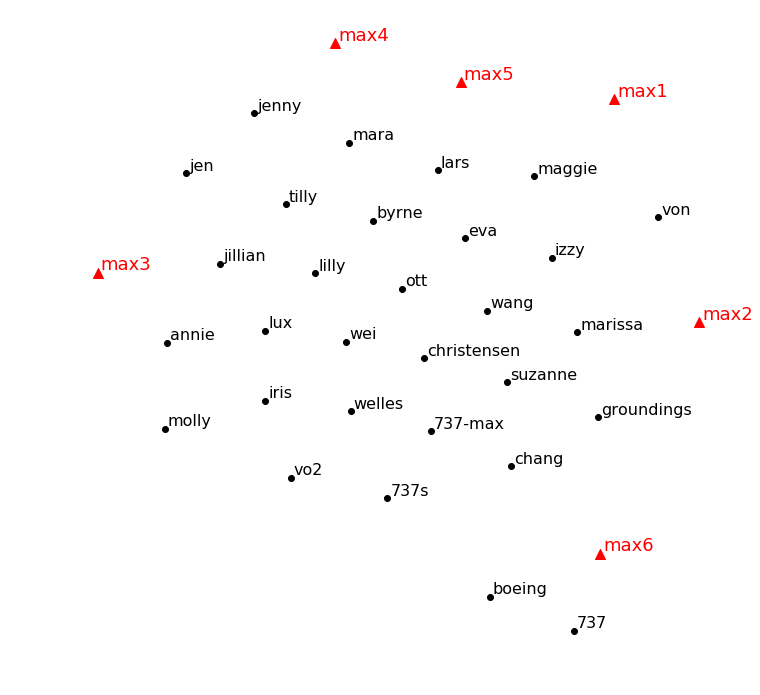

In [19]:
tsne_plot([model1, model2, model3, model4, model5, model6], 'max', topn=5)

## 3.2 Table

Following table lists the top nearest neighbors (words that have highest cosine similarities with the key word) of the key word 'lakers'. It confirms with Breaking News Tracking on Trade Rumors from Semantic Role Labeling that breaking news of Anthony Davis and Lakers happened because of the trade rumors.

In [8]:
model_list = [model1, model2, model3, model4, model5, model6]
time_labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar']
get_table(model_list, 'lakers', time_labels, topn=10)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).


Rank,Oct,Nov,Dec,Jan,Feb,Mar
str2,str22,str18,str21,str18,str18,str21
1,los_angeles_lakers,lebron_james,los_angeles_lakers,los_angeles_lakers,los_angeles_lakers,los_angeles_lakers
2,lebron_james,los_angeles_lakers,lebron_james,pelicans,lebron_james,lebron_james
3,lonzo_ball,lonzo_ball,lonzo_ball,lebron_james,clippers,clippers
4,spurs,cavs,clippers,lonzo_ball,pelicans,kevin_durant
5,pelicans,clippers,brandon_ingram,anthony_davis,boston_celtics,lonzo_ball
6,brandon_ingram,brandon_ingram,kevin_durant,cavs,kyle_kuzma,lebron
7,kevin_durant,raptors,anthony_davis,boston_celtics,tobias_harris,giannis_antetokounmpo
8,clippers,spurs,raptors,rockets,anthony_davis,magic_johnson
9,rajon_rondo,lebron,golden_state_warriors,houston_rockets,celtics,pelicans


## 3.3 Changing Words with Absolute Drift 

Following figure displays the cosine similarity changes with respect to 'unemployment'. The blue line represents the word 'gdp', the orange line refers to 'boosting', and green line is 'record-low'. One thing we can infer from this figure is that as the economy ('gdp') shows a strong signal ('boosting') in the first quarter of 2019, the unemployment rate reaches a 'record-low' position. According to National Public Radio, the first quarter's gross domestic product of U.S. grew at an annual rate of 3.2%, which is a strong improvement compared to the 2.2% at the end of last year. In addition, the Labor Department reported that 196,000 jobs were added in March, and the unemployment is near 50-year lows.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


<Figure size 432x288 with 0 Axes>

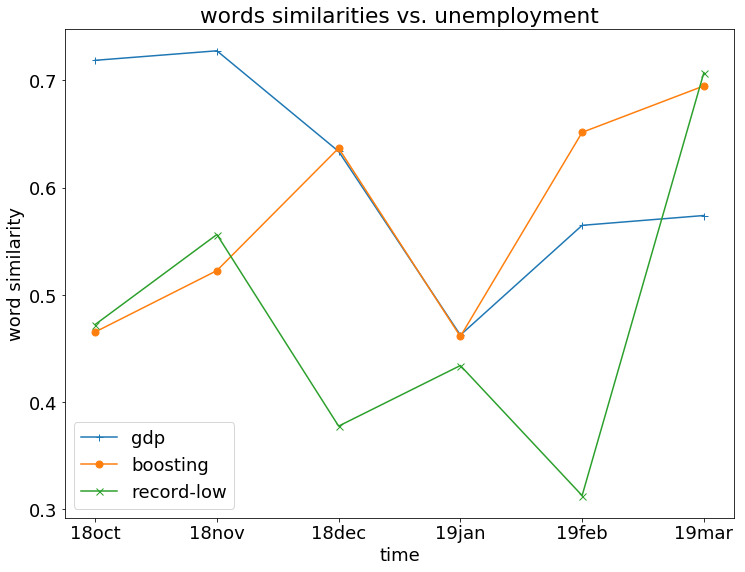

In [9]:
plot_similarity(model_list, ['gdp', 'boosting', 'record-low'], 'unemployment')